## StateReducer
* 기본 리듀서
    - 덮어쓰기
    - ![](images/reducer_default.png)


In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

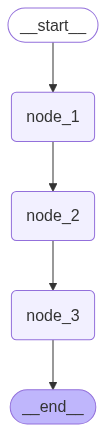

In [2]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END

# 상태 정의
class DocumentState(TypedDict):
    query: str
    documents: List[str]

# Node 1: query 업데이트
def node_1(state: DocumentState) -> DocumentState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가
def node_2(state: DocumentState) -> DocumentState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: DocumentState) -> DocumentState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}


# 그래프 빌드
builder = StateGraph(DocumentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
graph


In [4]:
graph.invoke({"query": "hello"})

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---


{'query': 'hello', 'documents': ['doc2.pdf', 'doc4.pdf', 'doc5.pdf']}

* add 리듀서
    - 메시지 리스트 등에서 이전 상태에 새로운 값을 추가할 때 사용
    - ![](images/reducer_add.png)

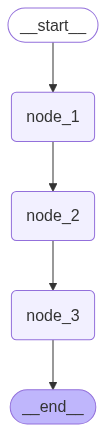

In [5]:
from operator import add
from typing import Annotated, TypedDict

class ReducerState(TypedDict):
    query: str
    documents: Annotated[List[str], add]

# Node 1: query 업데이트
def node_1(state: ReducerState) -> ReducerState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가
def node_2(state: ReducerState) -> ReducerState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: ReducerState) -> ReducerState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프 빌드
builder = StateGraph(ReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
graph

In [6]:
# 그래프 실행
graph.invoke({"query":"world"})

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---


{'query': 'world',
 'documents': ['doc1.pdf',
  'doc2.pdf',
  'doc3.pdf',
  'doc2.pdf',
  'doc4.pdf',
  'doc5.pdf']}

* custom 리듀서
    - 중복 제거, 정렬 등 특수한 상태 관리를 하는 사용자 정의 리듀서

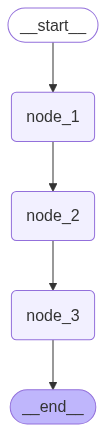

In [7]:
from typing import TypedDict, List, Annotated

# Custom reducer: 중복된 문서를 제거하며 리스트 병합
def reduce_unique_documents(left: list | None, right: list | None) -> list:
    """Combine two lists of documents, removing duplicates."""
    if not left:
        left = []
    if not right:
        right = []
    # 중복 제거: set을 사용하여 중복된 문서를 제거하고 다시 list로 변환
    return list(set(left + right))

# 상태 정의 (documents 필드 포함)
class CustomReducerState(TypedDict):
    query: str
    documents: Annotated[List[str], reduce_unique_documents]  # Custom Reducer 적용


# Node 1: query 업데이트
def node_1(state: CustomReducerState) -> CustomReducerState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가
def node_2(state: CustomReducerState) -> CustomReducerState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: CustomReducerState) -> CustomReducerState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프 빌드
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
graph

In [8]:
graph.invoke({"query":"hello world"})

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---


{'query': 'hello world',
 'documents': ['doc1.pdf', 'doc4.pdf', 'doc3.pdf', 'doc2.pdf', 'doc5.pdf']}

## MessageGraph
- LangChain의 ChatModel은 Message 객체 목록을 입력으로 처리 (StateGraph의 특수한 유형)
- 이러한 메시지들은 HumanMessage(사용자 입력)나 AIMessage(LLM 응답) 등 다양한 형태로 제공
### Messages State 정의
- 이전 대화 기록을 그래프 상태에 메시지 목록으로 저장하는 것이 유용
- 그래프 상태에 Message 객체 목록을 저장하는 키(채널)를 추가하고, 이 키에 리듀서 함수를 추가
- 리듀서 함수 선택:
    - operator.add를 사용하면: 새 메시지를 기존 목록에 단순히 추가
    - add_messages 함수를 사용하면:
        - 새 메시지는 기존 목록에 추가
        - 기존 메시지 업데이트도 올바르게 처리 (메시지 ID를 추적)
- ![](images/messageGraph.png)

In [9]:
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages
# LangGraph MessagesState라는 미리 만들어진 상태를 사용
from langgraph.graph import MessagesState
from typing import List
from langchain_core.documents import Document

class GraphState(MessagesState):
    # messages 키는 기본 제공 - 다른 키를 추가하고 싶을 경우 아래 주석과 같이 적용 가능
    documents: List[Document]
    grade: float
    num_generation: int
    
class GraphStateEqual(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages ]
    documents: List[Document]
    grade: float
    num_generation: int

In [10]:
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Chroma 인덱스 로드
vector_db = Chroma(
    embedding_function=embeddings_model,
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

# LLM 모델
llm = ChatOpenAI(model="gpt-4o-mini")

# RAG 체인 구성
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

system = """
You are a helpful assistant. Use the following context to answer the user's question:

[Context]
{context}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

# 검색기 정의
retriever = vector_db.as_retriever(
    search_kwargs={"k": 2}
)

# RAG 체인 구성
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# RAG 체인 실행
query = "채식주의자를 위한 메뉴를 추천해주세요."
response = rag_chain.invoke(query)

# 답변 출력
print(response)

주어진 메뉴에는 채식주의자를 위한 옵션이 포함되어 있지 않습니다. 하지만 일반적으로 채식주의자를 위한 메뉴는 샐러드, 야채 요리, 파스타 등 다양한 식물성 재료를 활용한 요리로 구성될 수 있습니다. 혹시 주변 레스토랑에서 채식주의자 메뉴를 찾아보시거나, 추가적인 요청이 있으시면 도와드릴 수 있습니다.


In [11]:
# RAG 수행 함수 정의
def retrieve_and_respond(state: GraphState):
    last_human_message = state['messages'][-1]

    # HumanMessage 객체의 content 속성에 접근
    query = last_human_message.content

    # 문서 검색
    retrieved_docs = retriever.invoke(query)

    # 응답 생성
    response = rag_chain.invoke(query)

    # 검색된 문서와 응답을 상태에 저장
    return {
        "messages": [AIMessage(content=response)],
        "documents": retrieved_docs
    }

In [16]:
from pydantic import BaseModel, Field

class GradeResponse(BaseModel):
    "A score for answers"
    score: float = Field(..., ge=0, le=1, description="A score from 0 to 1, where 1 is perfect")
    explanation: str = Field(..., description="An explanation for the given score")

# 답변 품질 평가 함수
def grade_answer(state: GraphState):
    messages = state['messages']
    question = messages[-2].content
    answer = messages[-1].content
    context = format_docs(state['documents'])

    grading_system = """You are an expert grader.
    Grade the following answer based on its relevance and accuracy to the question, considering the given context.
    Provide a score from 0 to 1, where 1 is perfect, along with an explanation."""

    grading_prompt = ChatPromptTemplate.from_messages([
        ("system", grading_system),
        ("human", "[Question]\n{question}\n\n[Context]\n{context}\n\n[Answer]\n{answer}\n\n[Grade]\n")
    ])

    grading_chain = grading_prompt | llm.with_structured_output(schema=GradeResponse, method="function_calling")

    grade_response = grading_chain.invoke({
        "question": question,
        "context": context,
        "answer": answer
    })

    # 답변 생성 횟수를 증가
    num_generation = state.get('num_generation', 0)
    num_generation += 1

    return {"grade": grade_response.score, "num_generation": num_generation}

In [17]:
from typing import Literal


def should_retry(state: GraphState) -> Literal["retrieve_and_respond", "generate"]:
    print("----GRADTING---")
    print("Grade Score: ", state["grade"])

    # 답변 생성 횟수가 3회 이상이면 "generate"를 반환
    if state["num_generation"] > 2:
        return "generate"

    # 답변 품질 평가점수가 0.7 미만이면 RAG 체인을 다시 실행
    if state["grade"] < 0.7:
        return "retrieve_and_respond"
    else:
        return "generate"

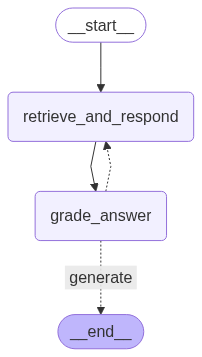

In [18]:
# 그래프 설정
builder = StateGraph(GraphState)
builder.add_node("retrieve_and_respond", retrieve_and_respond)
builder.add_node("grade_answer", grade_answer)

builder.add_edge(START, "retrieve_and_respond")
builder.add_edge("retrieve_and_respond", "grade_answer")
builder.add_conditional_edges(
    "grade_answer",
    should_retry,
    {
        "retrieve_and_respond": "retrieve_and_respond",
        "generate": END
    }
)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
graph

In [19]:
# 초기 상태
initial_state = {
    "messages": [HumanMessage(content="채식주의자를 위한 메뉴를 추천해주세요.")],
}

# 그래프 실행
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:", final_state)

----GRADTING---
Grade Score:  1.0
최종 상태: {'messages': [HumanMessage(content='채식주의자를 위한 메뉴를 추천해주세요.', additional_kwargs={}, response_metadata={}, id='8c8182cc-7e6d-4617-9d94-b5ddea909283'), AIMessage(content='제공된 메뉴 중에서는 채식주의자를 위한 옵션이 없습니다. 하지만 일반적으로 채식주의자를 위한 메뉴로는 다양한 샐러드, 야채 수프, 구운 야채 요리, 혹은 아보카도를 활용한 요리들이 좋은 선택이 될 수 있습니다. \n\n혹시 다른 종류의 메뉴나 추가 정보를 원하신다면 말씀해 주세요!', additional_kwargs={}, response_metadata={}, id='b9f4d0c1-175f-4b41-928c-ea6917a7710f')], 'documents': [Document(id='89eec7aa-e5a8-43a9-ac13-8279b5b7f909', metadata={'menu_name': '연어 타르타르', 'source': './data/restaurant_menu.txt', 'menu_number': 2}, page_content='3. 연어 타르타르\n   • 가격: ₩18,000\n   • 주요 식재료: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파\n   • 설명: 신선한 노르웨이산 생연어를 곱게 다져 아보카도, 케이퍼, 적양파와 함께 섞어 만든 타르타르입니다. 레몬 드레싱으로 상큼한 맛을 더했으며, 바삭한 브리오쉬 토스트와 함께 제공됩니다. 전채요리로 완벽한 메뉴입니다.'), Document(id='a8e0c237-25ae-4f90-9ed0-a8b16705f028', metadata={'menu_name': '시그니처 스테이크', 'menu_number': 0, 'source': './data/restaurant_menu.txt'}, page_content='1. 시그니처 스